# Определение возраста покупателей

Сетевой супермаркет внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

Цель проекта является построение модели, которая по фотографии определит приблизительный возраст человека.

Задачи проекта:

- Провести исследовательский анализ набора фотографий;
- Подготовить данные к обучению;
- Обучить нейронную сеть и рассчитать её качество.

## Исследовательский анализ данных

In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import seaborn as sns

In [2]:
def load(path):
    labels = pd.read_csv(path+'labels.csv')
    datagen = ImageDataGenerator(rescale=1./255)
 
    datagen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path+'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)
 
    return labels, datagen_flow

labels, datagen_flow = load('/datasets/faces/')

Found 7591 validated image filenames.


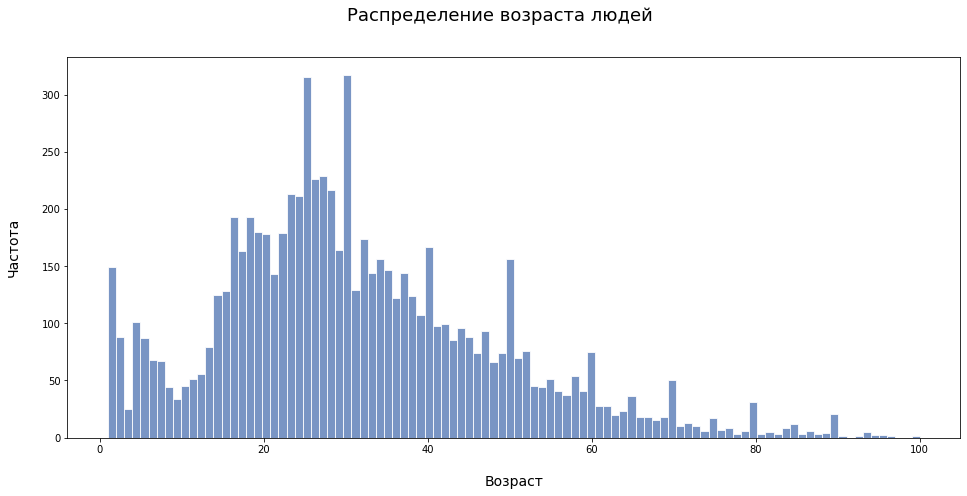

In [3]:
plt.figure(figsize=(16,7))
plt.suptitle('Распределение возраста людей', fontsize=18)
plt.ylabel('Частота' + "\n", fontsize=14)
plt.xlabel("\n" + 'Возраст', fontsize=14)
sns.set(style="darkgrid")
sns.histplot(data=labels, x="real_age", bins=100);

График распределение возраста людей в выборке показывает, что больше всего в выборке представлены люди за 25-30 лет, также на графике наблюдается небольшой хвост из редких значений людей возрастом за 60, т.е. в выборке мало фотографий пожилых. Наблюдаются выбросы значений на юбилейных возрастах, что может говорить о ошибочно указанном возрасте людей. 

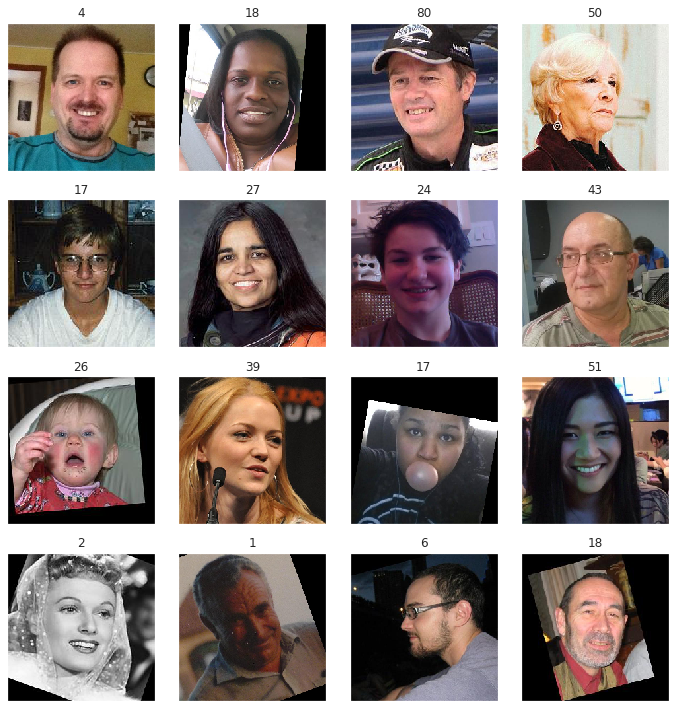

In [4]:
features, target = next(datagen_flow)
fig = plt.figure(figsize=(10,10))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.title(labels['real_age'][i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Выводы по анализу данных выборки, гистограммы и фото:

1. Выборка имеет достаточное количество данных для построения модели, но для увеличения качество MAE можно дополнить датасет различными аугментациями;
2. График распределение возраста людей показал, что выборке в основном представлены. Наблюдаются выбросы значений на юбилейных возрастах, что может говорить о ошибочно указанном возрасте людей. 
3. По фотографиям видно, что возраст некоторых людей указан неверно. Фотографии сделаны в разных условиях, что усложняет предсказания модели. В целом на всех фото крупным планом в хорошем качестве показано лицо, но встречаются варианты, где не видна лица. Аугментации, которые не исказят содержания фотографий, следующие - поворот на 30°, поворот по горизонтали, сдвигом по высоте и ширине на 0.2.

## Обучение модели

```python
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanAbsoluteError
import numpy as np
import pandas as pd
 
def load_train(path):
    labels = pd.read_csv(path+'labels.csv')
    datagen = ImageDataGenerator(
                  rescale=1./255,
                  rotation_range=30.0,
                  width_shift_range=0.25, 
                  height_shift_range=0.20,
                  horizontal_flip=True,
                  validation_split=0.25)
 
    train_datagen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path+'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)
 
    return train_datagen_flow
 
def load_test(path):
    labels = pd.read_csv(path+'labels.csv')
    datagen = ImageDataGenerator(
                  rescale=1./255,
                  validation_split=0.25)
 
    valid_datagen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path+'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)
 
    return valid_datagen_flow
 
def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet',
                    include_top=False)
 
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mae',
                  metrics=[MeanAbsoluteError()])
 
    return model
 
 
def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):
 
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)
 
    return model 
```

```

Train for 178 steps, validate for 60 steps
Epoch 1/10
178/178 - 169s - loss: 11.7048 - mean_absolute_error: 11.7062 - val_loss: 19.4122 - val_mean_absolute_error: 19.4032
Epoch 2/10
178/178 - 95s - loss: 7.9883 - mean_absolute_error: 7.9882 - val_loss: 18.4748 - val_mean_absolute_error: 18.4681
Epoch 3/10
178/178 - 94s - loss: 7.4174 - mean_absolute_error: 7.4172 - val_loss: 16.5585 - val_mean_absolute_error: 16.4889
Epoch 4/10
178/178 - 94s - loss: 6.8903 - mean_absolute_error: 6.8908 - val_loss: 9.1344 - val_mean_absolute_error: 9.1013
Epoch 5/10
178/178 - 94s - loss: 6.5644 - mean_absolute_error: 6.5651 - val_loss: 7.4976 - val_mean_absolute_error: 7.5307
Epoch 6/10
178/178 - 94s - loss: 6.2068 - mean_absolute_error: 6.2073 - val_loss: 6.8517 - val_mean_absolute_error: 6.8800
Epoch 7/10
178/178 - 94s - loss: 6.0108 - mean_absolute_error: 6.0113 - val_loss: 8.8173 - val_mean_absolute_error: 8.7878
Epoch 8/10
178/178 - 94s - loss: 5.7732 - mean_absolute_error: 5.7735 - val_loss: 6.6396 - val_mean_absolute_error: 6.6292
Epoch 9/10
178/178 - 94s - loss: 5.6427 - mean_absolute_error: 5.6430 - val_loss: 7.2752 - val_mean_absolute_error: 7.3156
Epoch 10/10
178/178 - 94s - loss: 5.3614 - mean_absolute_error: 5.3618 - val_loss: 6.7299 - val_mean_absolute_error: 6.7557

60/60 - 9s - loss: 6.7299 - mean_absolute_error: 6.7557
Test MAE: 6.7557

```

## Анализ обученной модели

Качество модели MAE на тренировочной выборке равен 6,73, а на валидоцонной выборке MAE = 6.76.

Для увеличения качества модели были произведены следующие действия:

* обучающая выборка расширена изображениями, повернутыми на 30°, перевёрнутыми по горизонтали, сдвигом по высоте и ширине;
* использована архитектура ResNet50;
* использован выходной слой с 1 нейронам;
* значение learning rate алгоритма Adam равна 0.0001;
* использованы 10 эпох.